In [203]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import math


import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (e.g. sklearn and seaborn)




import os


# Reading train data
df_credit_reports = pd.read_csv('./dataset/credit_reports.csv')
df_users = pd.read_csv('./dataset/users.csv')

# 1. Inspecting data globally

## Missing data

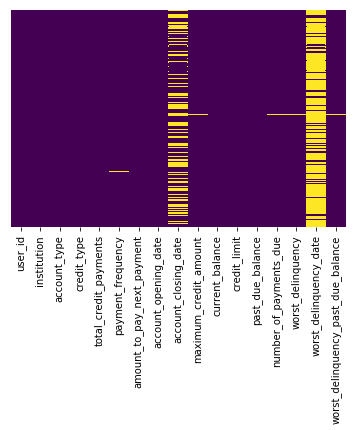

In [204]:
# Only dates are significantly missing in dates

sns.heatmap(pd.concat(objs=[df_credit_reports], axis=0).reset_index(drop=True).isnull(),yticklabels=False,cbar=False,cmap='viridis')

In [205]:
# No missin data for 
assert df_users.isnull().sum().sum() == 0

## Correlations

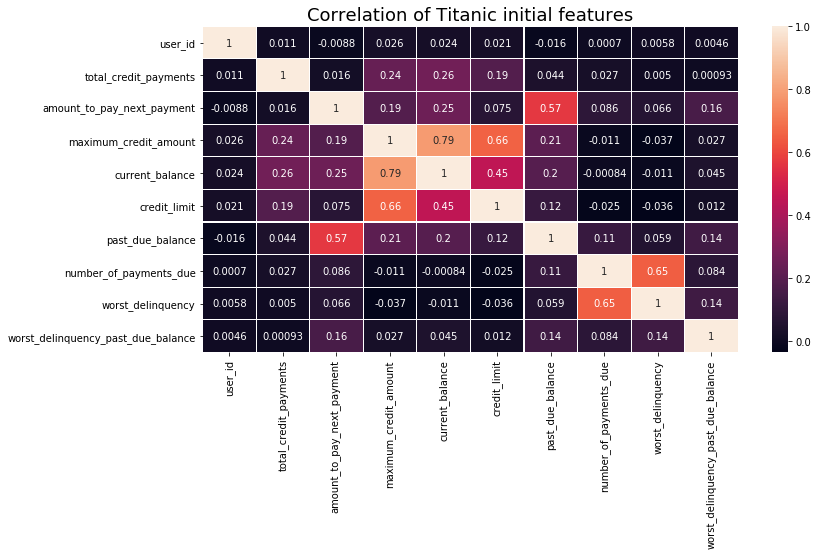

In [206]:
# Set-up figure
plt.figure(figsize=(12, 6))
# Title
plt.title('Correlation of Titanic initial features', fontsize=18)
# Correlation matrix
sns.heatmap(df_credit_reports.corr(), annot=True, linewidths=0.2)

# 2. Data merge

In [209]:
df_users.rename(index=str,columns={'id':'user_id'}, inplace=True)

In [210]:
df=pd.merge(df_users, df_credit_reports, on=['user_id'])

In [211]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 16309 entries, 0 to 16308
Data columns (total 20 columns):
user_id                               16309 non-null int64
monthly_income                        16309 non-null int64
monthly_outcome                       16309 non-null int64
class                                 16309 non-null int64
institution                           16309 non-null object
account_type                          16309 non-null object
credit_type                           16309 non-null object
total_credit_payments                 16268 non-null float64
payment_frequency                     16308 non-null object
amount_to_pay_next_payment            16304 non-null float64
account_opening_date                  16309 non-null object
account_closing_date                  9068 non-null object
maximum_credit_amount                 16307 non-null float64
current_balance                       16304 non-null float64
credit_limit                          16296 non-null

# Anomaly detection 

Balances are the most important features! Without them we cannot estimate losses/earnings. 
Let us have a look at the type of clients for which these data are missing:

In [261]:
anomaly_list=['current_balance','past_due_balance','past_due_balance','worst_delinquency_past_due_balance','amount_to_pay_next_payment']

anomalous_clients= df[ df[anomaly_list[0]].isnull() | df[anomaly_list[1]].isnull() | df[anomaly_list[2]].isnull() | df[anomaly_list[3]].isnull() | df[anomaly_list[4]].isnull() ]
anomalous_clients

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
1948,96,3256,7581,0,BANCO,Revolvente,Tarjeta de Crédito,NaN,Mensual,10236.0,5/24/16,NaN,7000.0,10236.0,7000.0,10236.0,NaN,NaN,NaN,NaN
1949,96,3256,7581,0,FINANCIERA,Pagos Fijos,Préstamo Personal,104.0,Semanal,212.0,7/12/16,NaN,9040.0,8730.0,NaN,847.0,NaN,NaN,NaN,NaN
1950,96,3256,7581,0,AUTOMOTRIZ,Pagos Fijos,Compra de Automóvil,60.0,Mensual,5260.0,12/18/14,NaN,73969.0,73969.0,130393.0,2638.0,NaN,NaN,NaN,NaN
8439,488,834,422,0,BANCOS,Pagos Fijos,Préstamo Personal,10.0,Catorcenal,NaN,5/25/16,10/13/16,7197.0,NaN,7197.0,NaN,NaN,NaN,NaN,NaN
8442,488,834,422,0,SERVICIO DE TELEVISION DE PAGA,Sin Límite Preestablecido,Línea de Crédito,NaN,Mensual,700.0,5/28/16,NaN,3000.0,700.0,NaN,NaN,2.0,2.0,8/31/16,1450.0
8443,488,834,422,0,COMUNICACIONES,Revolvente,Línea de Crédito,NaN,Mensual,8843.0,4/2/11,NaN,1005.0,8843.0,1200.0,8843.0,NaN,NaN,NaN,NaN
8444,488,834,422,0,COMUNICACIONES,Revolvente,Línea de Crédito,NaN,Mensual,7691.0,1/29/11,NaN,1885.0,7691.0,1500.0,7691.0,NaN,NaN,NaN,NaN
8445,488,834,422,0,SERVICIOS,Sin Límite Preestablecido,Línea de Crédito,NaN,Mensual,800.0,3/4/16,NaN,3000.0,800.0,NaN,NaN,NaN,NaN,NaN,NaN
8446,488,834,422,0,COMUNICACIONES,Sin Límite Preestablecido,Línea de Crédito,NaN,Mensual,NaN,9/4/09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8447,488,834,422,0,COBRANZA,Revolvente,Tarjeta de Crédito,12.0,Mensual,43372.0,6/24/11,NaN,NaN,43372.0,1.0,43372.0,NaN,NaN,NaN,NaN


In [255]:
# Observed that these all have some trace of delinquency/debt. 
anomalous_clients.describe()

,user_id,monthly_income,monthly_outcome,class,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,13.000000,13.000000,13.000000,13.0,6.000000,8.000000,11.000000,8.000000,7.000000,8.00000,1.0,1.0,1.0
mean,397.538462,1392.923077,2074.076923,0.0,54.666667,9639.250000,16201.636364,19292.625000,22184.428571,15477.62500,2.0,2.0,1450.0
std,171.903372,1062.117261,3139.429180,0.0,39.908228,14186.400074,21739.959233,25896.411875,47829.173736,15860.99315,NaN,NaN,NaN
min,96.000000,834.000000,422.000000,0.0,10.000000,212.000000,1005.000000,700.000000,1.000000,847.00000,2.0,2.0,1450.0
25%,488.000000,834.000000,422.000000,0.0,20.750000,775.000000,3000.000000,5968.250000,1350.000000,6427.75000,2.0,2.0,1450.0
50%,488.000000,834.000000,422.000000,0.0,53.500000,6475.500000,7197.000000,8786.500000,7000.000000,9539.50000,2.0,2.0,1450.0
75%,488.000000,834.000000,422.000000,0.0,86.250000,9191.250000,19561.000000,18520.000000,7598.500000,19109.50000,2.0,2.0,1450.0
max,488.000000,3256.000000,7581.000000,0.0,104.000000,43372.000000,73969.000000,73969.000000,130393.000000,43372.00000,2.0,2.0,1450.0


In [268]:
# The following anomaly dection fuction cleans separates such 
# clients.
df.dropna(subset=anomaly_list,inplace=True)

# 2 Inspecting and addressing missing values of Cathegorical features

## Balances are among the most critical features so we start here

## worst_delinquency

In [283]:
df[df['worst_delinquency'].isnull()]

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
7291,402,1328843,930751,1,COMUNICACIONES,Sin Límite Preestablecido,Línea de Crédito,NaN,Mensual,1102.0,10/14/10,NaN,2348.0,0.0,20000.0,0.0,0.0,NaN,NaN,0.0
7292,402,1328843,930751,1,BANCO,Revolvente,Tarjeta de Crédito,NaN,Mensual,0.0,9/1/13,NaN,46259.0,13457.0,50000.0,0.0,0.0,NaN,NaN,0.0
7293,402,1328843,930751,1,TIENDA COMERCIAL,Revolvente,Tarjeta de Crédito,NaN,Mensual,0.0,3/29/09,NaN,666.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0
7294,402,1328843,930751,1,BANCO,Pagos Fijos,Préstamo Personal,48.0,Mensual,0.0,5/1/16,NaN,259000.0,0.0,259000.0,0.0,0.0,NaN,NaN,0.0
7295,402,1328843,930751,1,BANCO,Revolvente,Tarjeta de Crédito,NaN,Mensual,0.0,3/1/10,NaN,26615.0,0.0,33000.0,0.0,0.0,NaN,NaN,0.0
7296,402,1328843,930751,1,BANCO,Pagos Fijos,Préstamo Personal,24.0,Mensual,0.0,11/1/14,NaN,153480.0,0.0,153480.0,0.0,0.0,NaN,NaN,0.0
7297,402,1328843,930751,1,CIA Q OTORGA,Sin Límite Preestablecido,Tarjeta de Crédito,NaN,Mensual,0.0,8/1/12,NaN,893.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0
7298,402,1328843,930751,1,BANCO,Revolvente,Tarjeta de Crédito,NaN,Mensual,0.0,12/21/07,NaN,12644.0,0.0,21400.0,0.0,0.0,NaN,NaN,0.0
7299,402,1328843,930751,1,BANCO,Revolvente,Tarjeta de Crédito,NaN,Mensual,0.0,1/1/12,NaN,11925.0,0.0,61000.0,0.0,0.0,NaN,NaN,0.0
7300,402,1328843,930751,1,BANCO,Revolvente,Tarjeta de Crédito,NaN,Mensual,0.0,12/21/07,NaN,12644.0,0.0,1.0,0.0,0.0,NaN,NaN,0.0


In [291]:
def fill_worst_delinquency_nan(columns):
    worst_delinquency = columns[0]
    worst_delinquency_past_due_balance = columns[1]
    
    if (worst_delinquency_past_due_balance == 0.0) & pd.isnull(worst_delinquency) :
        return 0.
    else:
        return worst_delinquency

In [297]:
df['worst_delinquency']=df[['worst_delinquency','worst_delinquency_past_due_balance']].apply(fill_worst_delinquency_nan,axis=1)
assert df['worst_delinquency'].isnull().sum()==0

## worst_delinquency_date: Worst delinquency date

In [430]:
def convert_worst_date_to_year(columns):
    worst_del_date = columns[0]
    worst_del_balance = columns[1]
    
    if worst_del_balance == 0.0:
        return 0
    
    elif (type(worst_del_date)==str) & (str(worst_del_date)[-3]=='/'):
        return (18-int(worst_del_date[-2:]))
    
    else:
        return worst_del_date


In [431]:
df['worst_delinquency_year']=df[['worst_delinquency_date','worst_delinquency_past_due_balance']].apply(convert_worst_date_to_year,axis=1)

assert df['worst_delinquency_year'].isnull().sum()==0

df['worst_delinquency_year'].unique()

array([0, 2, 1, 7, 5, 4, 3, 10, 6, 11, 13, 12, 16, 15, 14, 8, 9, 17,
       '0000-00-00'], dtype=object)

We unfortunately still have three wrong entries:

In [432]:
df[df['worst_delinquency_year']=='0000-00-00']

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,...,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance,worst_delinquency_year
13194,792,56924,53883,0,KONFIO-10222,Pagos Fijos,Préstamo Personal,24.0,Quincenal,3456.0,...,NaN,50000.0,32115.0,0.0,0.0,3.0,2.0,0000-00-00,7378.0,0000-00-00
13196,792,56924,53883,0,SOCIEDAD FINANCIERA DE OBJETO MULTIPLE,Pagos Fijos,Préstamo Personal,26.0,Semanal,0.0,...,NaN,24048.0,0.0,0.0,0.0,2.0,1.0,0000-00-00,939.0,0000-00-00
13198,792,56924,53883,0,TELEFONIA CELULAR,Revolvente,Línea de Crédito,0.0,Mensual,433.0,...,NaN,433.0,433.0,1000.0,199.0,1.0,1.0,0000-00-00,199.0,0000-00-00


In [421]:
df[df['worst_delinquency_year']=='0000-00-00'][['account_opening_date','total_credit_payments','payment_frequency']]

,account_opening_date,total_credit_payments,payment_frequency
13194,9/1/16,24.0,Quincenal
13196,8/4/16,26.0,Semanal
13198,8/30/16,0.0,Mensual


In [ ]:
# Given, the past_due_balance, we can assume that the worst_d

## account_closing_date

In [379]:
df['account_closing_date'].isnull().sum(), df['account_closing_date'].notnull().sum()

(7232, 9064)

In [382]:
#Roughly half of the labels are missing for this feature. 
#The code below counts how many entries have the same user_id, 
#"the same account opening date", but several closing dates.

# Only 577 such cases were found, against 5667. 
# Besides a closer look shows many entries have several accounts
# open on the same date but close on several different dates!
# Since we cannot impute missing data on this way,
# a sencible thing to do would be turning closing date into 
# the boolean: reported or not reported for a given entry. 
# See cell below.

nan_plus_dates=0
only_nan=0
df_cd=df[df['account_closing_date'].isnull()]
for i in set(df_cd['user_id']):
    df_temp1=df[(df['user_id']==i)]
    for j in set(df_temp1['account_opening_date']):
        df_temp2=df_temp1[df_temp1['account_opening_date']==j]    
        temp=list(df_temp2['account_closing_date'])
        if (len(temp)>1) & ('/' in str(temp)) & ('nan' in str(temp)) : 
            nan_plus_dates+=1
        if (len(temp)==1) & ('nan' in str(temp)) : 
            only_nan+=1
nan_plus_dates, only_nan


(577, 5667)

# Other stuff

In [ ]:
df[df['account_closing_date'].isnull()][['user_id','class','account_opening_date','account_closing_date']].head(100)

In [ ]:
def fill_account_closing_date(columns):
    user_id = columns[0]
    account_closing_date = columns[1]
    account_opening_date = columns[2]
    
    if (worst_delinquency_past_due_balance == 0.0) & pd.isnull(worst_delinquency) :
        return 0.
    else:
        return worst_delinquency

## institution: Institution granting the loan.

In [233]:
assert df['institution'].isnull().sum()==0

In [234]:
def feature_labels(feature):
    return df[feature].unique(), df[feature].nunique()
    
feature_labels('institution')

(array(['MERCANCIA PARA HOGAR Y OFICINA', 'KONFIO', 'TELEFONIA CELULAR',
        'AUTOMOTRIZ', 'BANCO', 'FINANCIERA', 'COMUNICACIONES',
        'TIENDA COMERCIAL', 'MICROFINANCIERA',
        'ADMINISTRADORAS DE CARTERA', 'SERVICIOS', 'HIPOTECAGOBIERNO',
        'CIA Q  OTORGA', 'COBRANZA', 'MERCANCIA PARA LA CONSTRUCCION',
        'BANCOS', 'SERVICIO DE TELEVISION DE PAGA', 'TIENDA DEPARTAMENTAL',
        'TELEFONIA LOCAL Y DE LARGA DISTANCIA', 'VENTA POR CATALOGO',
        'GOBIERNO', 'SOCIEDADES FINANCIERAS POPULARES',
        'SOCIEDAD FINANCIERA DE OBJETO MULTIPLE', 'FONDOS Y FIDEICOMISOS',
        'GUBERNAMENTALES', 'COOPERATIVA', 'COMERCIAL', 'SERVS. GRALES.',
        'CAJAS DE AHORRO', 'COMPANIA DE FINANCIAMIENTO AUTOMOTRIZ',
        'AUTOFINANCIAMIENTO', 'TIENDA DE ROPA', 'ARRENDADORA', 'SIC',
        'COMPANIA DE PRESTAMO PERSONAL', 'OTRAS FINANCIERA',
        'FONDOS Y FIDEIC', 'BIENES RAICES', 'SOFOL PRESTAMO PERSONAL',
        'FACTORAJE', 'COOPERATIVA DE AHORRO Y CREDITO',

In [235]:
df['institution'].describe()

count     16309
unique       54
top       BANCO
freq       4285
Name: institution, dtype: object

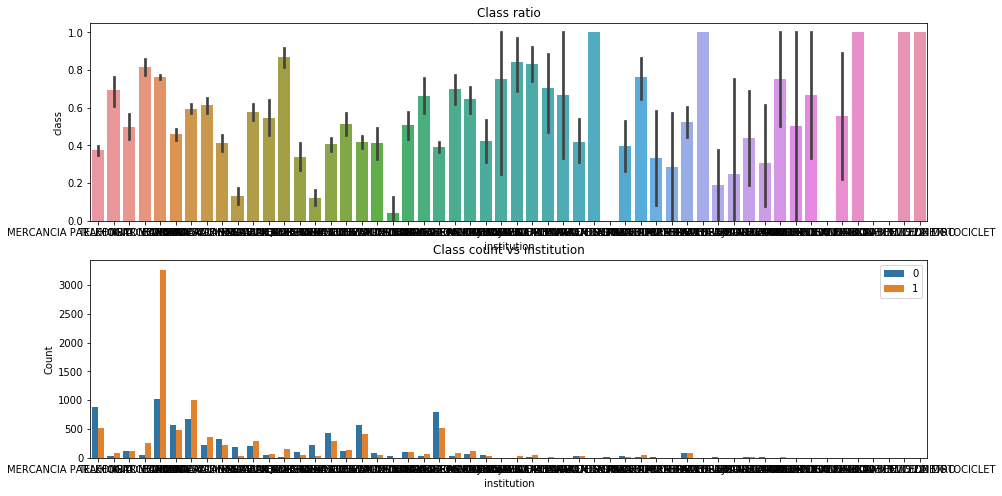

In [236]:
def Class_and_count_vs(feature_str):
    fig, ax = plt.subplots(2 , 1, figsize=(15, 8))
    axx=ax.flat

    g1=sns.catplot(x=feature_str,y="class",data=df,kind="bar",ax=axx[0])
    g1.set_ylabels("Class probability")
    axx[0].set_title('Class ratio')

    plt.close(2);
    axx[1]=sns.countplot(x = feature_str, hue = 'class', data = df)
    axx[1].set_title('Class count vs '+feature_str)

    axx[1].set_xlabel(feature_str)
    axx[1].set_ylabel('Count')
    axx[1].legend(['0','1'],loc = 1)
    
Class_and_count_vs('institution')

## account_type: Type of account for the institution.

In [237]:
assert df['account_type'].isnull().sum()==0
feature_labels('account_type')

(array(['Pagos Fijos', 'Revolvente', 'Sin Límite Preestablecido',
        'Hipoteca', 'Crédito Prendario', 'Quirografiario',
        'Crédito Refaccionario', 'Crédito de Habilitación de Avío'],
       dtype=object), 8)

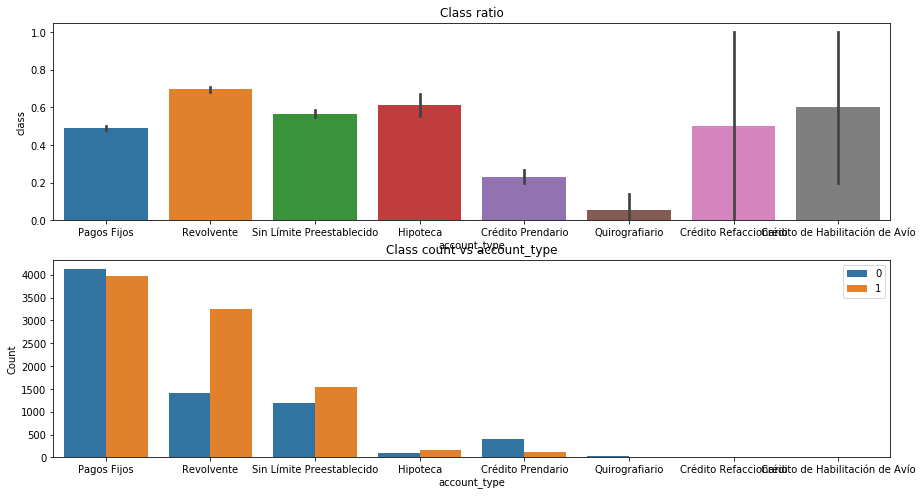

In [238]:
Class_and_count_vs('account_type')

## credit_type: Type of loan granted by the institution.

In [239]:
assert df['credit_type'].isnull().sum()==0
feature_labels('credit_type')

(array(['Línea de Crédito', 'Préstamo Personal ',
        'Crédito Personal al Consumo', 'Compra de Automóvil',
        'Tarjeta de Crédito', 'Otros (Múltiples Créditos)',
        'Bienes Raíces', 'Préstamo de Nomina', 'Crédito al Consumo',
        'Arrendamiento', 'Aparatos - Muebles', 'Arrendamiento Automotriz',
        'Crédito Fiscal', 'Préstamo Garantizado', 'Hipotecario O Vivienda',
        'Mejoras a la Casa', 'Grupo Solidario', 'Desconocido',
        'Física Actividad Empresarial', 'Préstamo Empresarial',
        'Préstamo Quirografiario', 'Tarjeta Departamental',
        'Préstamo para estudiante', 'Préstamo no garantizado', 'Factoraje',
        'Banca Comunal'], dtype=object), 26)

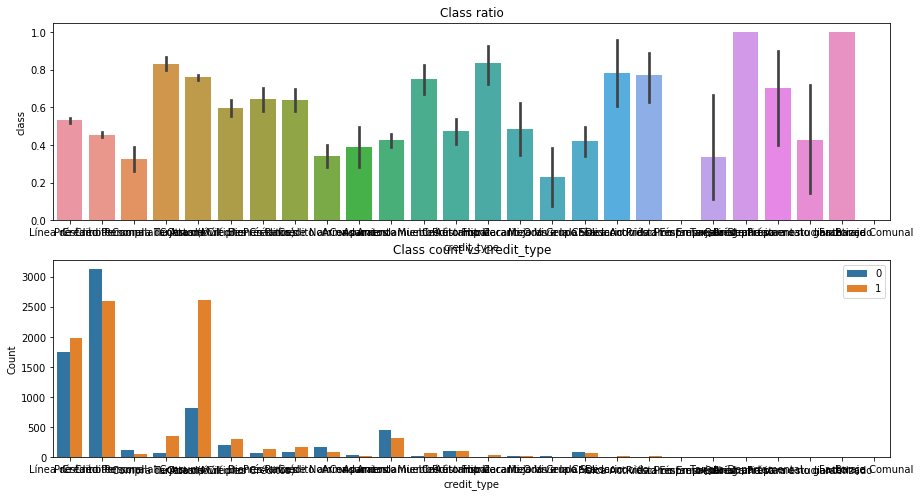

In [240]:
Class_and_count_vs('credit_type')

## total_credit_payments: Length of the credit (in amount of payments).
## payment_frequency: Frequency of the payments.

In [287]:
df['total_credit_payments'].isnull().sum()

41

In [284]:
feature_labels('total_credit_payments')

(array([7.80e+01, 8.00e+01, 1.02e+02, 1.20e+02, 1.20e+01, 2.60e+01,
        1.00e+03, 0.00e+00, 7.20e+01, 2.40e+01, 1.00e+00, 6.00e+00,
        5.30e+01, 3.60e+02, 5.20e+01, 1.00e+02, 5.00e+01, 3.60e+01,
        7.00e+00, 4.80e+01, 6.00e+01, 4.00e+00, 6.50e+01, 1.80e+01,
        3.00e+01, 1.60e+01, 3.00e+00, 1.00e+01, 9.00e+01, 3.90e+01,
        5.90e+01, 1.50e+01, 4.30e+01, 2.00e+01, 1.10e+01, 7.00e+01,
        4.00e+01, 8.50e+01, 2.00e+00, 7.30e+01, 1.19e+02, 9.00e+02,
        1.40e+01, 1.30e+01, 1.28e+02, 3.10e+01, 9.00e+00, 2.10e+01,
        1.50e+02, 3.70e+01, 1.90e+01, 1.04e+02, 9.60e+01, 1.08e+02,
        9.10e+01, 2.08e+02, 9.70e+01, 5.10e+01, 9.90e+01, 2.20e+01,
        2.30e+01, 1.70e+01, 2.70e+01, 4.70e+01, 6.40e+01, 1.32e+02,
        3.12e+02, 8.00e+00, 4.10e+01, 1.56e+02, 4.20e+01,      nan,
        2.50e+01, 7.20e+02, 3.50e+01, 2.40e+02, 9.50e+01, 5.00e+00,
        4.90e+01, 7.50e+01, 4.50e+02, 3.01e+02, 1.43e+02, 7.10e+01,
        1.80e+02, 1.59e+02, 1.31e+02, 4.60e+01, 

In [285]:
df['total_credit_payments'].describe()

count    15392.000000
mean        23.623960
std         79.412354
min          0.000000
25%          0.000000
50%          1.000000
75%         16.000000
max       1800.000000
Name: total_credit_payments, dtype: float64

In [262]:
feature_labels('payment_frequency')

(array(['Semanal', 'Quincenal', 'Mensual', 'Catorcenal', 'Bimestral',
        'Pago mínimo para cuentas revolventes', 'Anual', 'Trimestral',
        'Deducción del salario', nan], dtype=object), 9)

In [280]:
df[df['payment_frequency'].isnull()]

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance


We are going to get of "Una sola exhibición", for two reasons. Firstly, Konfio website does not offer this 
service. Secondly, I haven't found a way to estimate when such loans are due. There is also one missing value of this feature, we will get rid of this.

In [249]:
df[(df['payment_frequency']=='Una sola exhibición')   ].describe()

,user_id,monthly_income,monthly_outcome,class,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,875.000000,8.750000e+02,8.750000e+02,875.000000,875.0,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000
mean,432.274286,3.686819e+04,3.755839e+04,0.401143,1.0,1512.898286,4080.713143,1549.748571,906.611429,1310.259429,0.498286,0.428571,1498.450286
std,281.909934,1.317252e+05,1.904313e+05,0.490410,0.0,12590.335389,11302.198948,12615.319261,2333.940709,12593.045631,2.418641,1.983423,12617.277121
min,34.000000,2.000000e+01,1.000000e+01,0.000000,1.0,0.000000,611.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,154.000000,9.740000e+02,4.867500e+03,0.000000,1.0,0.000000,1850.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,422.000000,8.753000e+03,8.256000e+03,0.000000,1.0,0.000000,2600.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,626.000000,2.695800e+04,1.826000e+04,1.000000,1.0,0.000000,4515.000000,0.000000,1500.000000,0.000000,0.000000,0.000000,0.000000
max,996.000000,1.805322e+06,2.755130e+06,1.000000,1.0,222166.000000,222166.000000,222166.000000,50000.000000,222166.000000,24.000000,25.000000,222166.000000


In [278]:
df=df[ (df.payment_frequency != 'Una sola exhibición')  ]
df=df[(df['payment_frequency'].isnull()!=True )]

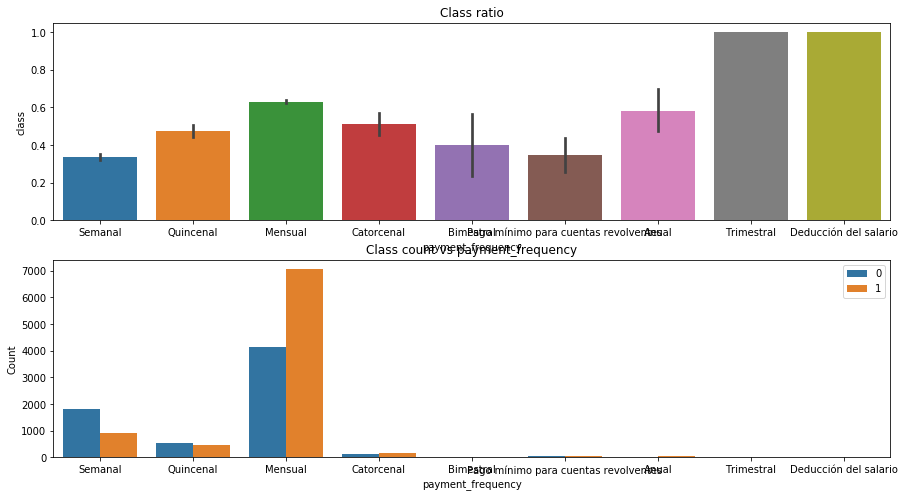

In [281]:
Class_and_count_vs('payment_frequency')

## amount_to_pay_next_payment

In [93]:
# only 5 missin data from teh same client
df[df['amount_to_pay_next_payment'].isnull()]
# Since this is a single client we better droped
# Improvement: search the distribution and replace

,user_id,monthly_income,monthly_outcome,class,institution,account_type,credit_type,total_credit_payments,payment_frequency,amount_to_pay_next_payment,account_opening_date,account_closing_date,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_date,worst_delinquency_past_due_balance
8439,488,834,422,0,BANCOS,Pagos Fijos,Préstamo Personal,10.0,Catorcenal,NaN,5/25/16,10/13/16,7197.0,NaN,7197.0,NaN,NaN,NaN,NaN,NaN
8446,488,834,422,0,COMUNICACIONES,Sin Límite Preestablecido,Línea de Crédito,NaN,Mensual,NaN,9/4/09,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8448,488,834,422,0,BANCO,Pagos Fijos,Préstamo Personal,95.0,Quincenal,NaN,6/24/11,7/17/15,33000.0,NaN,NaN,37072.0,NaN,NaN,NaN,NaN
8449,488,834,422,0,BANCO,Revolvente,Tarjeta de Crédito,NaN,Mensual,NaN,10/27/10,12/6/13,13122.0,NaN,8000.0,13122.0,NaN,NaN,NaN,NaN
8450,488,834,422,0,BANCO,Pagos Fijos,Préstamo Personal,47.0,Mensual,NaN,11/10/10,6/27/11,26000.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN


### Before plotting the distribution of this variable, we need to normalize to montly

In [99]:
df=df[df.user_id != 488]

In [100]:
df['amount_to_pay_next_payment'].describe()

count    1.629700e+04
mean     2.773574e+03
std      2.144957e+04
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      5.820000e+02
max      1.263964e+06
Name: amount_to_pay_next_payment, dtype: float64

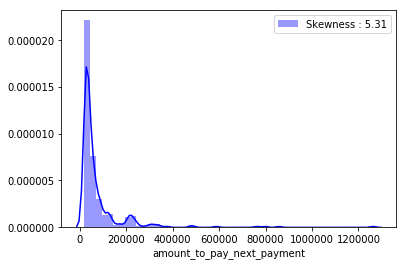

In [157]:
temp=df[df['amount_to_pay_next_payment'] >100000 ]['amount_to_pay_next_payment']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

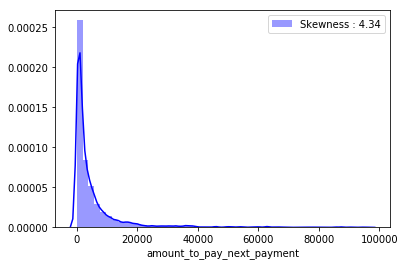

In [161]:
temp=df[(df['amount_to_pay_next_payment'] <=100000) & (df['amount_to_pay_next_payment'] >0) ]['amount_to_pay_next_payment']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

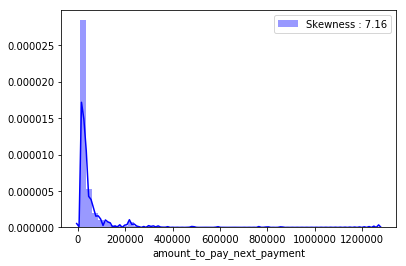

In [160]:
temp=df[ (df['amount_to_pay_next_payment'] >10000)]['amount_to_pay_next_payment']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")

The distribution is defintely not gaussian!

2319      798623.0
2659     1263964.0
3315      857867.0
8213      764858.0
10194     589569.0
Name: amount_to_pay_next_payment, dtype: float64

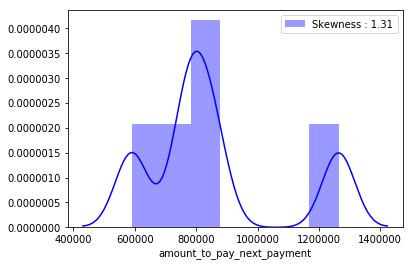

In [163]:
temp=df[df['amount_to_pay_next_payment'] >500000 ]['amount_to_pay_next_payment']
sns.distplot(temp, color="b", label="Skewness : %.2f"%(temp.skew())).legend(loc="best")
temp

In [167]:
payment_frequency_labels=df['payment_frequency'].unique()
payment_frequency_labels

array(['Semanal', 'Quincenal', 'Mensual', 'Catorcenal',
       'Una sola exhibición', 'Bimestral',
       'Pago mínimo para cuentas revolventes', 'Anual', 'Trimestral',
       'Deducción del salario', nan], dtype=object)

In [ ]:
keys = payment_frequency_labels
values = [4 * 28 / 30, 2  , 1, 2 * 28 / 30, ]
dictionary = dict(zip(keys, values))
print(dictionary)
{'a': 1, 'b': 2, 'c': 3}

In [177]:
df[df['payment_frequency']=='Una sola exhibición'].describe()

,user_id,monthly_income,monthly_outcome,class,total_credit_payments,amount_to_pay_next_payment,maximum_credit_amount,current_balance,credit_limit,past_due_balance,number_of_payments_due,worst_delinquency,worst_delinquency_past_due_balance
count,875.000000,8.750000e+02,8.750000e+02,875.000000,875.0,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000,875.000000
mean,432.274286,3.686819e+04,3.755839e+04,0.401143,1.0,1512.898286,4080.713143,1549.748571,906.611429,1310.259429,0.498286,0.428571,1498.450286
std,281.909934,1.317252e+05,1.904313e+05,0.490410,0.0,12590.335389,11302.198948,12615.319261,2333.940709,12593.045631,2.418641,1.983423,12617.277121
min,34.000000,2.000000e+01,1.000000e+01,0.000000,1.0,0.000000,611.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,154.000000,9.740000e+02,4.867500e+03,0.000000,1.0,0.000000,1850.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,422.000000,8.753000e+03,8.256000e+03,0.000000,1.0,0.000000,2600.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,626.000000,2.695800e+04,1.826000e+04,1.000000,1.0,0.000000,4515.000000,0.000000,1500.000000,0.000000,0.000000,0.000000,0.000000
max,996.000000,1.805322e+06,2.755130e+06,1.000000,1.0,222166.000000,222166.000000,222166.000000,50000.000000,222166.000000,24.000000,25.000000,222166.000000


In [190]:
df[(df['payment_frequency']=='Una sola exhibición') & (df['number_of_payments_due'] >1)].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 49 entries, 479 to 16018
Data columns (total 20 columns):
user_id                               49 non-null int64
monthly_income                        49 non-null int64
monthly_outcome                       49 non-null int64
class                                 49 non-null int64
institution                           49 non-null object
account_type                          49 non-null object
credit_type                           49 non-null object
total_credit_payments                 49 non-null float64
payment_frequency                     49 non-null object
amount_to_pay_next_payment            49 non-null float64
account_opening_date                  49 non-null object
account_closing_date                  5 non-null object
maximum_credit_amount                 49 non-null float64
current_balance                       49 non-null float64
credit_limit                          49 non-null float64
past_due_balance                     